In [229]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [230]:
df_default = pd.read_csv("data\default.csv")

In [231]:
df_default.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


### Entendendo o dado

In [232]:
df_default.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
default    10000 non-null object
student    10000 non-null object
balance    10000 non-null float64
income     10000 non-null float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


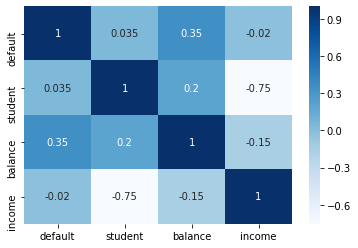

In [89]:
sns.heatmap(df_default.corr(), cmap="Blues", annot=True)

(<matplotlib.axes._subplots.AxesSubplot at 0x1e3b8222f28>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e3b8222f28>)

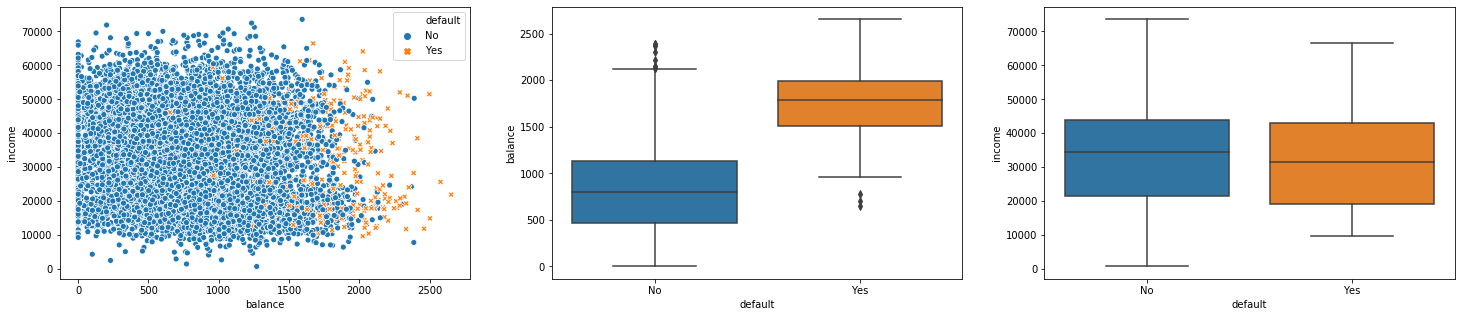

In [33]:
plt.figure(figsize=(25, 5))
plt.subplot(1, 3, 1),sns.scatterplot(x="balance", y="income", hue="default", style="default", data=df_default)
plt.subplot(1, 3, 2),sns.boxplot(x="default", y="balance", data=df_default)
plt.subplot(1, 3, 3),sns.boxplot(x="default", y="income", data=df_default)

### Transformando Contínuo para Categorico

In [233]:
from sklearn.preprocessing import LabelEncoder

In [234]:
lb = LabelEncoder()
df_default.loc[:, ["student"]] = lb.fit_transform(df_default.student)

In [235]:
lb_2 = LabelEncoder()
df_default.loc[:, ["default"]] = lb.fit_transform(df_default.default)

In [236]:
df_default.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


### Modelando

In [237]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

#### Threshold 0.5

In [238]:
X = df_default[["student", "balance", "income"]]
y = df_default.default 

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In [80]:
lm = LogisticRegression()
lm.fit(X_train, y_train)

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [81]:
lm.coef_

array([[-2.48174102e-06,  4.03319621e-04, -1.23918830e-04]])

In [90]:
lm.intercept_

array([-1.91004954e-06])

### Predict

In [91]:
predicao = lm.predict(X_test)

In [94]:
pd.DataFrame(metrics.confusion_matrix(y_test, predicao))

,0,1
0,1943,1
1,56,0


In [126]:
print(metrics.classification_report(y_test, predicao))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1944
           1       0.00      0.00      0.00        56

    accuracy                           0.97      2000
   macro avg       0.49      0.50      0.49      2000
weighted avg       0.94      0.97      0.96      2000



#### Thredshold 0.2

In [124]:
predicao_prob = lm.predict_proba(X_test)

predicao2 = np.where(predicao_prob[:, 1] > 0.20, 1, 0)

In [127]:
pd.DataFrame(metrics.confusion_matrix(y_test, predicao2))

,0,1
0,1803,141
1,49,7


In [128]:
print(metrics.classification_report(y_test, predicao2))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1944
           1       0.05      0.12      0.07        56

    accuracy                           0.91      2000
   macro avg       0.51      0.53      0.51      2000
weighted avg       0.95      0.91      0.93      2000



### Ajustando os pesos

In [240]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [241]:
class_weights

array([ 0.51766533, 14.65201465])

In [242]:
lm2 = LogisticRegression(class_weight={0:class_weights[0], 1: class_weights[1]})
lm2.fit(X_train, y_train)

C:\Users\Henrique\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0,
                   class_weight={0: 0.5176653293645658, 1: 14.652014652014651},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=None, solver='warn', tol=0.0001,
                   verbose=0, warm_start=False)

In [243]:
predicao3 = lm2.predict(X_test)

In [244]:
pd.DataFrame(metrics.confusion_matrix(y_test, predicao3))

,0,1
0,1670,270
1,9,51


In [245]:
print(metrics.classification_report(y_test, predicao3))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1940
           1       0.16      0.85      0.27        60

    accuracy                           0.86      2000
   macro avg       0.58      0.86      0.60      2000
weighted avg       0.97      0.86      0.90      2000



In [247]:
metrics.accuracy_score(y_test, predicao3)

0.8605

In [252]:
prediprob = lm2.predict_proba(X_test)

In [253]:
prediprob =  prediprob[:, 1]

In [254]:
ns_probs = [0 for _ in range(len(prediprob))]

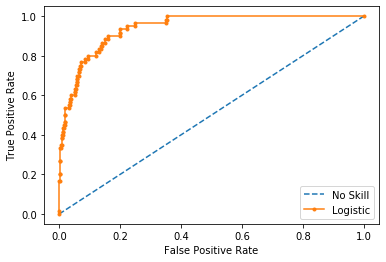

In [257]:
ns_auc = metrics.roc_auc_score(y_test, ns_probs)
lr_auc = metrics.roc_auc_score(y_test, prediprob)

ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, prediprob)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()